# Self-organizing maps
## Description:

Self-organizing maps have been used extensively for condition-based maintenance, where quantization errors of test data referring to the self-organizing maps of healthy training data have been used as features. Researchers have used minimum quantization error as a health indicator, which is sensitive to noise in the training data. Some other researchers have used the average of the quantization errors as a health indicator, where the best matching units of the trained self-organizing maps are required to be convex. These requirements are not always satisfied.

### Working of Algorithm : 

#### Training : 

It finds the Best Matching units (BMU) i.e the coordinates of neurons which has weights closest to the input sample , the norm used here is Euclidean Distance.Then we update the group of neurons which resembles input sample in a small region around the BMU by using radius as the metric around it. We update their weights such that , those group of neurons around the BMU of each input sample moves towards it. So this way we are mapping high dimensional datapoints into 2D  grid of neurons. Then to remove the effect of Noise dominated best matching units extracted from the map trained by the healthy training data are removed by setting a threshold called Minimum BMU per neuron, since we assume that noise to data ratio is small , so we remove the neurons which has BMU hits less than the threshold .So the rest are used as healthy references. Finally the model is saved as pickle file in a relative path given

#### Evaluate or Detection of anomalies :

We get the saved model's file path , from that we load the model and detect anomalies on the test data using the below logic: 

Then For a given test data observation, the k-nearest neighbor algorithm is applied to identify neighbors of the observation that occur in the references. Then the Euclidean distance between the test data observation and the centroid of the neighbors is calculated as a health indicator. Then we get anomaly score which are distance of test data from centroid of clusters formed by KNN where no of neighbors again an user defined argument. Finally we normalise the anomaly scores and to detect the anomalies , anomaly threshold of default value : 3 is set and user can also set anomaly threshold.

### Note : 

For mean or level shift data differencing of data must be done before training inorder to detect the level shifts.  So diff_order is taken as argument as part of training_args

In [1]:
import writefile_run as writefile_run

In [2]:
filename = '../../anomaly_detectors/som_knn_detector/som_knn_wrapper.py'

In [3]:
%%writefile_run $filename

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os


# Importing dependency files
from anomaly_detectors.reader_writer import db_properties as db_props
from anomaly_detectors.reader_writer import writer_configs as write_args
from anomaly_detectors.utils.preprocessors import *
from anomaly_detectors.utils.data_handler import *
from anomaly_detectors.utils.error_codes import error_codes
from anomaly_detectors.utils import type_checker as type_checker
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.utils import reader_helper
from anomaly_detectors.utils import make_ackg_json
from anomaly_detectors.som_knn_detector import som_knn_detector as som_detector
from anomaly_detectors.som_knn_detector import som_knn_module as som_model


import traceback


import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

/home/rohithram/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

# Learning

In [5]:
%%writefile_run $filename -a



ideal_train_kwargs_type  = {
            'som_shape':tuple,
            'input_feature_size':int,
            'time_constant':float,
            'minNumPerBmu':int,
            'no_of_neighbors':int,
            'initial_radius':float,
            'initial_learning_rate':float,
            'n_iterations':int,
            'N':int,    
            'diff_order':int,
            'is_train':bool,
            'epochs':int,
            'batch_size':int,
            'to_plot':bool,
            'test_frac':float
        }


ideal_eval_kwargs_type = {
            'model_path':str,
            'to_plot':bool,
            'anom_thres':float
        }


mode_options = ['detect only','detect and log','log only']

In [6]:
%%writefile_run $filename -a


def train(json_data,network_shape=None,input_feature_size=None,time_constant=None,minNumPerBmu=2,
          no_of_neighbours=10,init_radius=None,init_learning_rate=0.01,N=100,diff_order=1,is_train=True
          ,epochs=4,batch_size=4,to_plot=True,test_frac=0.5):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in json_string  and parses json 
                            and gives list of dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class som_knn_detector defined in som_knn_detector.py, which takes in
                            data and algorithm parameters as argument and trains and saves the model and returns
                            the model file path where it saved
        *make_acknowledgement_json - Its function to Make acknowlegement json imported from make_ackg_json.py
        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries, db_properties and table name as args and gives out response code.
        
        Arguments :
        Required Parameter:
            json_data: The Json object in the format of the input json given from reader api
            
        Optional Parameter 
                mode : mode has 3 options -> 'detect only','detect and log' , 'log only'
                    Default: 'detect only'
                network_shape : (Type : Tuple (x,y) ) where x is no of rows of the grid of neuron layer and y is the no of columns of grid. So Total no of neurons in a single layer is (x*y)
                    Default: (8,8)
                input_feature_size: Positive Integer representing the no of features in the input data for which anomaly to be detected 
                    Default: Will be no of metric's given as the input , For ex: For two metrics given the feature size will be taken as 2 since this is a multivariate algorithm
                    Customised input : Give no of features wanted to be extracted per metric (yet to do)
                    Note: (Do not give unrelated metrics together in input data , since all metrics are analyzed together i.e Multivariate)

                time_constant: positive float, Exponential decay factor to decrease the neighborhood radius around BMU
                    Default: n_iterations/(log(init_radius)) , It's calculated in the program
                
                minNumPerBmu: positive integer , It is a minimum no of BMU hits for a neuron. Used to minimise the effect of noise in the data
                    Default : 3
                no_of_neighbors: positive integer , It is no of neighbors for KNN algorithm.
                    Default: 3
                initial_radius : positive float, initial radius to find the group of neurons around each BMU
                    Default: 0.4
                initial_learning_rate : positive float , It is learning rate for the algo
                    Default  : 0.01
                diff_order : positive integer, It is order of differencing to be done on the raw data 
                    Default : 0 
                    Note : use 1 or more for mean shift dataset
                epochs: positive integer , no of epochs to train
                    Default: 4
                batch_size : positive integer, no of samples in data to be processed simultaneously
                    Default: 4
                test_frac: positive float, Ratio of test : train data
                    Default : 0.2
                to_plot : Boolean .Give True to see the plots of change-points detected and False if there is no need for plotting
                    Default : True
                
                
        '''
        
        
        #algorithm arguments

        model_input_args = {
            'som_shape':network_shape,
            'input_feature_size':None,
            'time_constant':None,
            'minNumPerBmu':minNumPerBmu,
            'no_of_neighbors':no_of_neighbours,
            'initial_radius':init_radius,
            'initial_learning_rate':init_learning_rate,
            'n_iterations':None,
            'N':N,    
            'diff_order':diff_order
        }
        
        #Training arguments
        training_args = {
            'is_train':True,
            'epochs':epochs,
            'batch_size':batch_size,
            'to_plot':to_plot,
            'test_frac':test_frac
        }
        
        
        
        #merging all algo arguments for params checking
        algo_kwargs = {**model_input_args,**training_args}
        
        '''
            #instantiating the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
        '''
        
        error_codes1 = error_codes()
              
        try: 
            
            
            
            
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=ideal_train_kwargs_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return json.dumps(res)
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data is not None and type(entire_data)!=dict)):
            
                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''
                
                # Output Format for training the model
                #models: is an list of filepaths where model saved
                out_json = {'header':'','models':[]}

                for i,data_per_asset in enumerate(entire_data):
                    if(len(data_per_asset)!=0):
                        assetno = pd.unique(data_per_asset['assetno'])[0]
                        data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]]
                                                                     )


                        print("Data of Asset no: {} \n {}\n".format(assetno,data_per_asset.head()))
                        cols = list(data_per_asset.columns[1:])

                        anomaly_detector = som_detector.Som_Detector(data = data_per_asset,model_input_args=model_input_args,
                                                                     training_args=training_args,
                                                                    eval_args=None)

                        model_path = (anomaly_detector.detect_anomalies())

                        model = {anomaly_detector.assetno:model_path}
                        
                        '''
                        TODO : Add code for saving the model into database here 
                        '''


                        out_json['models'].append(model)
                out_json['header'] = error_codes1['success']
                
                
               
                return json.dumps(out_json)
            elif(type(entire_data)==dict):
                return json.dumps(entire_data)
            else:
                '''
                Data empty error
                '''
                return json.dumps(error_codes1['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes1['unknown']['message']=str(e)
            return json.dumps(error_codes1['unknown'])

In [7]:
%%writefile_run $filename -a


def evaluate(json_data,model_path,mode=mode_options[0],to_plot=True,anom_thres=3.0):

    
        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in json_string  and parses json 
                            and gives list of dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class som_knn_detector defined in som_knn_detector.py, which takes in
                            data and algorithm parameters as argument and evaluates the data using the choosen model
                            and returns anomaly_indexes.      
        * make_acknowledgement_json - Its function to Make acknowlegement json imported from make_ackg_json.py
        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        
        Required Parameter:
            json_data: The Json object in the format of the input json given from reader api to evaluate the model
            model_path : Saved model file path in (string) format
        Optional Parameters: 
            mode - mode has 3 options 'detect only','detect and log','log only'
                Default: 'detect only'
            anom_thres : (Type : Positive float ) Anomaly threshold, used on anomaly scores estimated using K nearest neighbours on BMU of input test sample
                Default: 3.0
            to_plot : Boolean .Give True to see the plots of change-points detected and False if there is no need for plotting
                Default : True

        '''
        
        
        eval_args = {
            'model_path':model_path,
            'to_plot':to_plot,
            'anom_thres':anom_thres
        }
           
        '''
            #instantiating the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
        '''
        error_codes1 = error_codes()
            
        try: 
            
            
            #converting user given mode to all lower case
            mode = mode.lower()
            # Check for mode
            if(mode not in mode_options):
                error_codes1['param']['data']['argument']='mode'
                error_codes1['param']['data']['value']=mode
                error_codes1['param']['message']='should be one of {}'.format((mode_options))
                return json.dumps(error_codes1['param'])
            
            
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=eval_args,ideal_args_type=ideal_eval_kwargs_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return json.dumps(res)
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):
                
                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''
                    
                for i,data_per_asset in enumerate(entire_data):
                    if(len(data_per_asset)!=0):
                        assetno = pd.unique(data_per_asset['assetno'])[0]
                        data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]]
                                                                     )

                        print("Data of Asset no: {} \n {}\n".format(assetno,data_per_asset.head()))

                        anomaly_detector = som_detector.Som_Detector(data = data_per_asset,model_input_args=model_input_args,
                                                                     training_args=None,eval_args=eval_args)

                        anom_indexes = anomaly_detector.detect_anomalies()
                        anomaly_detectors.append(anomaly_detector)
                    
                        
                ack_json = {}
                
                if(mode==mode_options[0] or mode==mode_options[1]):
                    ack_json = make_ackg_json.make_ack_json(anomaly_detectors)
                if(mode==mode_options[1] or mode==mode_options[2]):
                    
                    '''
                    Instantiates writer class to write into local database with arguments given below
                    Used for Bulk writing
                    '''
                    sql_query_args = write_args.writer_kwargs
                    table_name = write_args.table_name
                    window_size = 10

                    writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                            table_name=table_name,window_size=window_size)

                    #called for mapping args before writing into db
                    res = writer.map_outputs_and_write()
                    if(res!=error_codes1['success']):
                        return json.dumps(res)
                    
                    if(bool(ack_json)==False):
                        ack_json['header'] = error_codes1['success']
                        
                return json.dumps(ack_json)
                
                
            else:
                '''
                Data empty error
                '''
                return json.dumps(error_codes1['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes1['unknown']['message']=str(e)
            return json.dumps(error_codes1['unknown'])

# Arguments

In [8]:
%%writefile_run $filename -a


reader_kwargs= lambda:{
            'assetno':['TSFAD_A1'],
            'from_timestamp':'',
            'to_timestamp':'',
            'con':'',
            'para_list':'',
            'source_type':'',
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
}

model_input_args = lambda :{
    'network_shape':(8,8),
    'input_feature_size':None,
    'time_constant':None,
    'minNumPerBmu':2,
    'no_of_neighbours':3,
    'init_radius':0.4,
    'init_learning_rate':0.01,
    'N':100,    
    'diff_order':1
}

training_args = lambda:{
            'is_train':True,
            'epochs':5,
            'batch_size':4,
            'to_plot':True,
            'test_frac':0.7
        }


        
eval_args = lambda: {
    'model_path':'',
    'to_plot':True,
    'anom_thres':3.0
}

In [9]:
'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['TSFAD_A1']
con = '52.224.236.31:4242'
src_type =  'opentsdb'
param = ['ec2_cpu_utilization_5f5533','rds_cpu_utilization_cc0c53']

from_timestamp=1392388200
to_timestamp=1393597320

## Training on data from opentsdb and saving it in a model

In [10]:
'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints and writing
to database
'''

reader_kwargs1 = reader_kwargs()
reader_kwargs1['assetno'] = assetno
reader_kwargs1['source_type']=src_type
reader_kwargs1['con'] = con
reader_kwargs1['from_timestamp'] = from_timestamp
reader_kwargs1['to_timestamp'] = to_timestamp
reader_kwargs1['para_list'] = param
model_input_args1 = model_input_args()
training_args1 = training_args()
training_args1['test_frac'] = 0.2
json_data = reader_helper.read(reader_kwargs=reader_kwargs1)
model_input_args1['diff_order'] = 0
kwargs1 = {**model_input_args1,**training_args1}
train_res = json.loads(train(**kwargs1,json_data=json_data))
# model_path1 = res['models'][0]
print(train_res)

http://52.224.236.31:4242/api/query?start=1392388200&end=1393597320&ms=true&m=max:none:ec2_cpu_utilization_5f5533{AssetNo=TSFAD_A1}
Data reader initialised 

{'code': '400', 'status': 'Bad Request', 'message': "Expecting value: line 1 column 1 (char 0),(<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f669eb3fd88>)", 'data': {}}


## Testing saved model on data from opentsdb

In [11]:
'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints with 
a trained model and writing anomalies to database
'''

reader_kwargs1 = reader_kwargs()
reader_kwargs1['assetno'] = assetno
reader_kwargs1['con'] = con
reader_kwargs1['source_type']=src_type
reader_kwargs1['from_timestamp'] = from_timestamp
reader_kwargs1['to_timestamp'] = to_timestamp
reader_kwargs1['para_list'] = param
eval_args1 = eval_args()
eval_args1['anom_thres'] = 3.0
eval_args1['model_path'] = train_res['models'][0][assetno[0]]
json_data = reader_helper.read(reader_kwargs1)
test_res = evaluate(**eval_args1,json_data=json_data,mode=mode_options[2])
print(test_res)

KeyError: 'models'

## Training on data from a list of sample csv datasets and saving them in a model and Testing it on the saved model


Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno       CO2   Methane
timestamp                                  
7808400000000  TSFAD_A1  0.090839 -1.170356
7808940000000  TSFAD_A1  0.028381 -1.340206
7809480000000  TSFAD_A1 -0.002849 -1.062837
7810020000000  TSFAD_A1 -0.002849 -0.811959
7810560000000  TSFAD_A1 -0.034078 -0.758978

Shape of the Entire dataset : torch.Size([296, 2])

Shape of Training dataset :torch.Size([89, 2]) and Test dataset :torch.Size([208, 2])

Dataset has 89 rows 2 columns


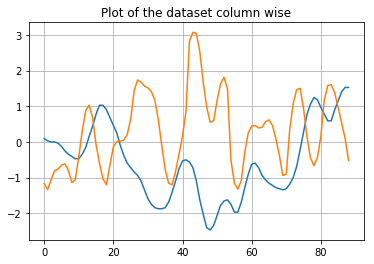

Network dimensions are 5 x 10 


Shape of differenced Training data : (89, 2)

Epoch : 0 completed

Epoch : 1 completed

Epoch : 2 completed

Epoch : 3 completed

Epoch : 4 completed


 Training successfully completed 


Saved model : som_trained_model_CO2_Methane_TSFAD_A1_1531441004832 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1531441004832

{'header': {'code': '200', 'status': 'OK'}, 'models': [{'TSFAD_A1': '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_CO2_Methane_TSFAD_A1_1531441004832'}]}
Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno       CO2   Methane
timestamp                                  
7808400000000  TSFAD_A1  0.090839 -1.170356
7808940000000  TSFAD_A1  0.028381 -1.340206
7809480000000  TSFAD_A1 -0.002849 -1.062837
7810020000000  TSFAD_A1 -0.002849 -0.811959
7810560000000  TSFAD_A1 -0.034078 -0.758978

Shape of the Entire dataset : 

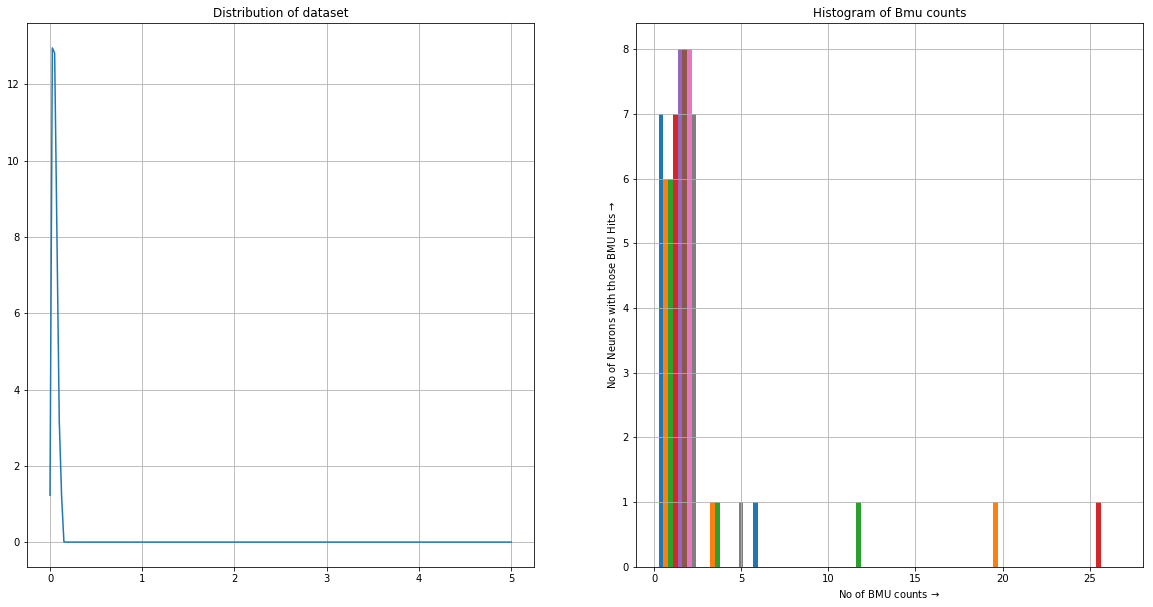

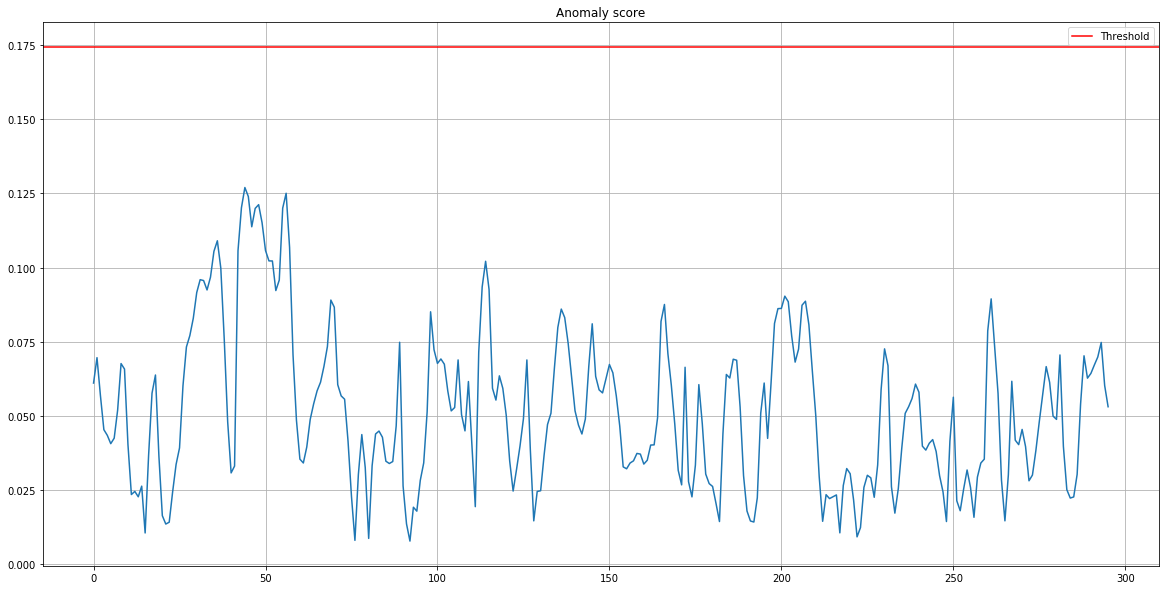

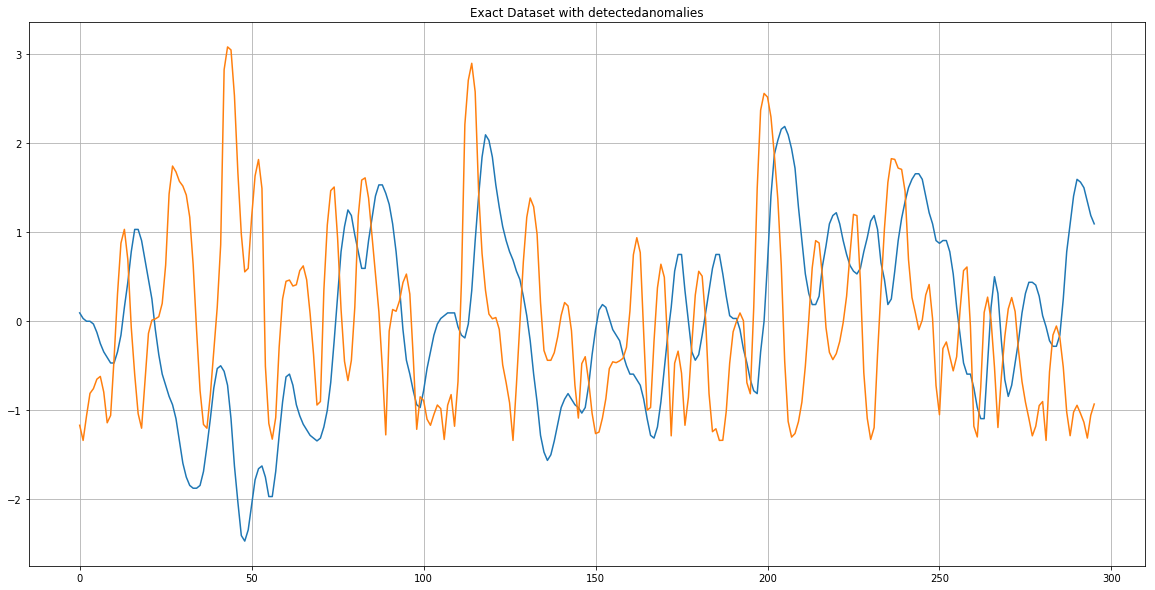


No of anomalies detected : 0, Fraction of data detected as anomaly : 0.0

 No of Anomalies detected = 0
{"header": "", "body": []}

Detecting anomalies for mean-monthly-temperature-1907-19.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                  assetno  Mean monthly temperature, 1907 ? 1972
timestamp                                                      
-1988150400000  TSFAD_A1                              -1.280625
-1985472000000  TSFAD_A1                              -0.477613
-1983052800000  TSFAD_A1                              -0.667301
-1980374400000  TSFAD_A1                               0.091451
-1977782400000  TSFAD_A1                              -0.110883

Shape of the Entire dataset : torch.Size([792, 1])

Shape of Training dataset :torch.Size([238, 1]) and Test dataset :torch.Size([555, 1])

Dataset has 238 rows 1 columns


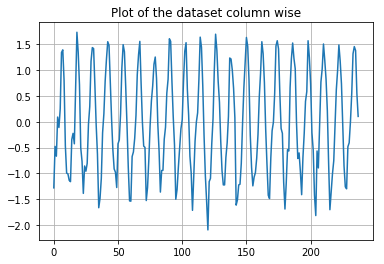

Network dimensions are 8 x 7 


Shape of differenced Training data : (238, 1)

Epoch : 0 completed

Epoch : 1 completed

Epoch : 2 completed

Epoch : 3 completed

Epoch : 4 completed


 Training successfully completed 


Saved model : som_trained_model_Meanmonthlytemperature19071972_TSFAD_A1_1531441007040 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1531441007040

{'header': {'code': '200', 'status': 'OK'}, 'models': [{'TSFAD_A1': '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_Meanmonthlytemperature19071972_TSFAD_A1_1531441007040'}]}
Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                  assetno  Mean monthly temperature, 1907 ? 1972
timestamp                                                      
-1988150400000  TSFAD_A1                              -1.280625
-1985472000000  TSFAD_A1                              -0.477613
-1983052800000  TSFAD_A1                     

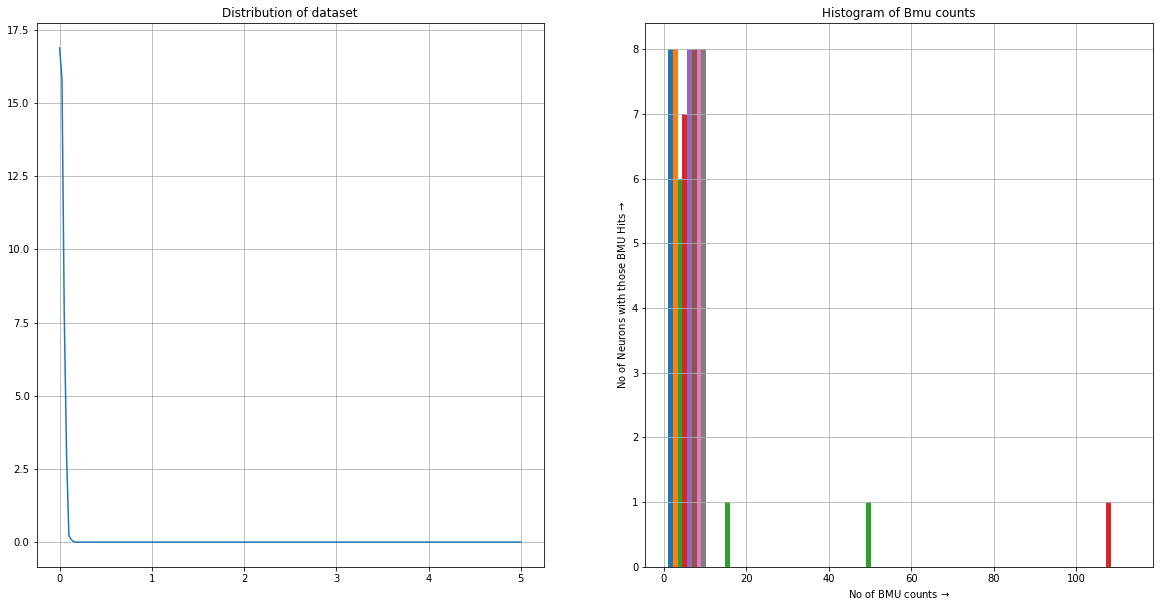

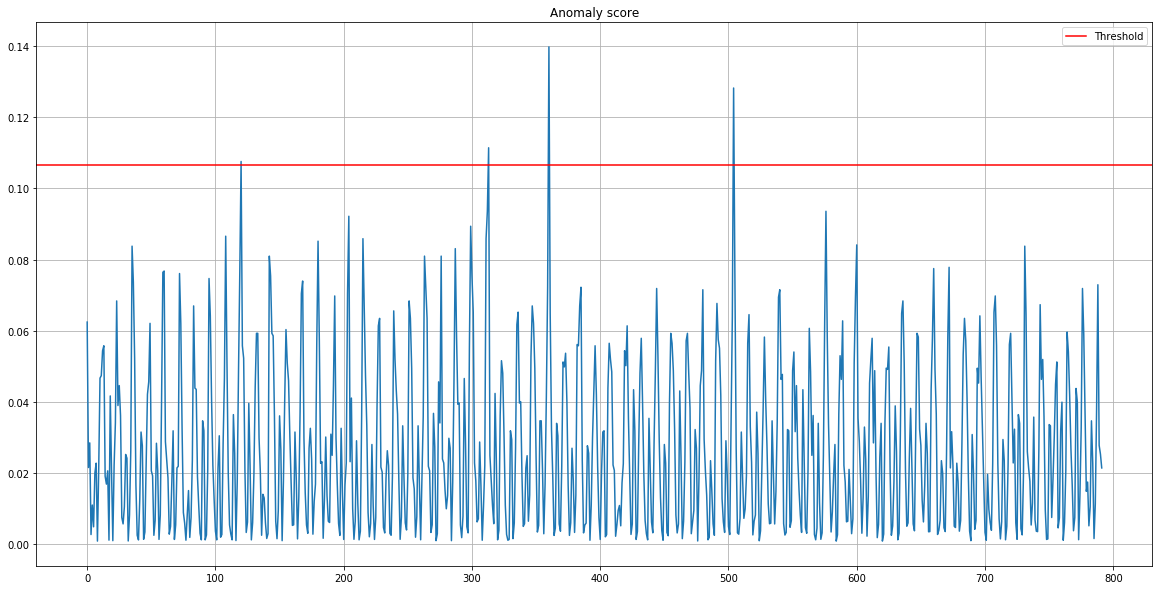

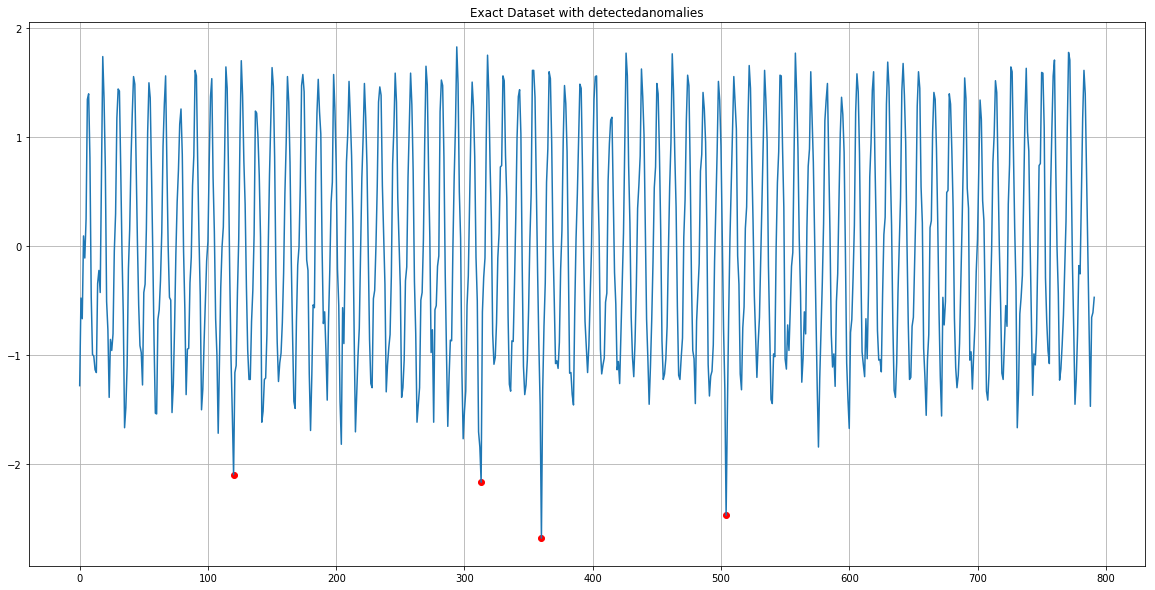


No of anomalies detected : 4, Fraction of data detected as anomaly : 0.005050505050505051

 No of Anomalies detected = 4
{"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "Mean monthly temperature, 1907 ? 1972", "datapoints": [{"from_timestamp": -1672531200000, "to_timestamp": -1672531200000, "anomaly_timestamp": [-1672531200000], "anomaly_code": "som"}, {"from_timestamp": -1164931200000, "to_timestamp": -1164931200000, "anomaly_timestamp": [-1164931200000], "anomaly_code": "som"}, {"from_timestamp": -1041379200000, "to_timestamp": -1041379200000, "anomaly_timestamp": [-1041379200000], "anomaly_code": "som"}, {"from_timestamp": -662688000000, "to_timestamp": -662688000000, "anomaly_timestamp": [-662688000000], "anomaly_code": "som"}]}]}]}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  \
timestamp       

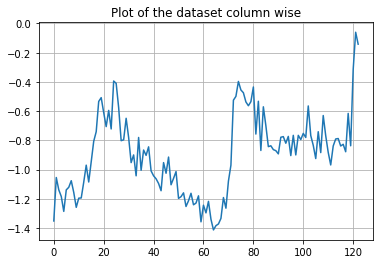

Network dimensions are 8 x 7 


Shape of differenced Training data : (123, 1)

Epoch : 0 completed

Epoch : 1 completed

Epoch : 2 completed

Epoch : 3 completed

Epoch : 4 completed


 Training successfully completed 


Saved model : som_trained_model_MonthlyUSfemale20yearsandoverunemploymentfigures10319481981_TSFAD_A1_1531441009460 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1531441009460

{'header': {'code': '200', 'status': 'OK'}, 'models': [{'TSFAD_A1': '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_MonthlyUSfemale20yearsandoverunemploymentfigures10319481981_TSFAD_A1_15314410'}]}
Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  \
timestamp                 
-694310400000  TSFAD_A1   
-691632000000  TSFAD_A1   
-689126400000  TSFAD_A1   
-686448000000  TSFAD_A1   
-683856000000  TSFAD_A1   

               Monthly U.S. female (20 years and over) une

Traceback (most recent call last):
  File "/home/rohithram/Desktop/internship/sprint1/som_branch/tsfad/rohithram/anomaly_detectors/som_knn_detector/som_knn_module.py", line 97, in evaluate
    assert self.allowed_nodes.shape[0] > 1
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-7-221b75c3c7f6>", line 97, in evaluate
    anom_indexes = anomaly_detector.detect_anomalies()
  File "/home/rohithram/Desktop/internship/sprint1/som_branch/tsfad/rohithram/anomaly_detectors/som_knn_detector/som_knn_detector.py", line 135, in detect_anomalies
    anom_indexes = test(eval_net,data.numpy(),anom_thres=anom_thres,to_plot=self.eval_args['to_plot'])
  File "/home/rohithram/Desktop/internship/sprint1/som_branch/tsfad/rohithram/anomaly_detectors/som_knn_detector/som_knn_detector.py", line 255, in test
    anomaly_metrics = model.evaluate(res_evaluateData)
  File "/home/rohithram/Desktop/internship/sprint1/som_

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                  assetno  \
timestamp                  
-3147897600000  TSFAD_A1   
-3137356800000  TSFAD_A1   
-3126816000000  TSFAD_A1   
-3116361600000  TSFAD_A1   
-3105820800000  TSFAD_A1   

                Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                         
-3147897600000                                           0.026580                 
-3137356800000                                           0.114869                 
-3126816000000                                           0.247302                 
-3116361600000                                           0.379735                 
-3105820800000                                           0.423880                 

Shape of the Entire dataset : torch.Size([207, 1])

Shape of Training dataset :torch.Size([63, 1]) and Test dataset :torch.Si

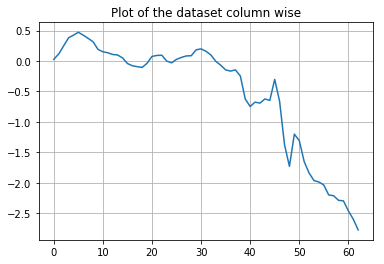

Network dimensions are 8 x 7 


Shape of differenced Training data : (63, 1)

Epoch : 0 completed

Epoch : 1 completed

Epoch : 2 completed

Epoch : 3 completed

Epoch : 4 completed


 Training successfully completed 


Saved model : som_trained_model_AlcoholdemandlogspiritsconsumptionperheadUK18701938_TSFAD_A1_1531441010004 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1531441010004

{'header': {'code': '200', 'status': 'OK'}, 'models': [{'TSFAD_A1': '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_AlcoholdemandlogspiritsconsumptionperheadUK18701938_TSFAD_A1_1531441010004'}]}
Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                  assetno  \
timestamp                  
-3147897600000  TSFAD_A1   
-3137356800000  TSFAD_A1   
-3126816000000  TSFAD_A1   
-3116361600000  TSFAD_A1   
-3105820800000  TSFAD_A1   

                Alcohol demand (log spirits consumption per hea

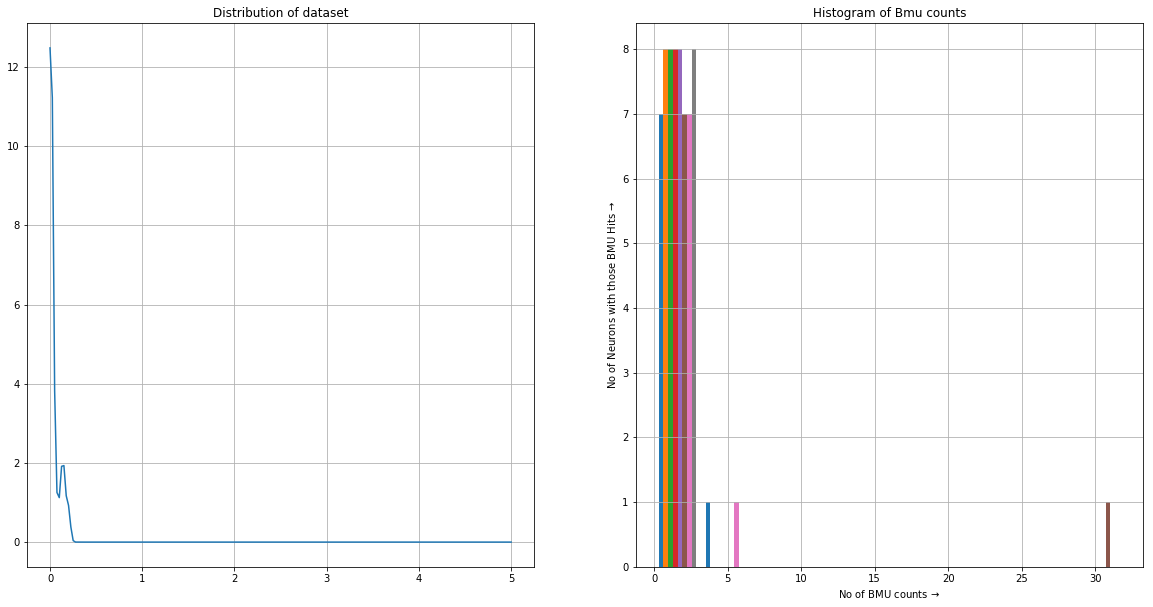

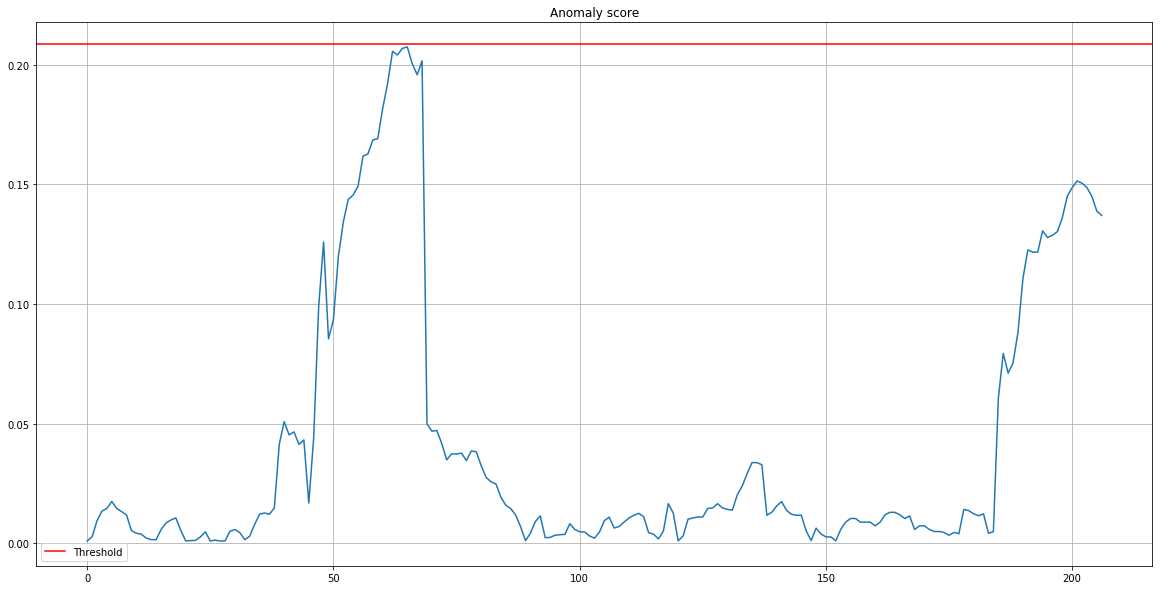

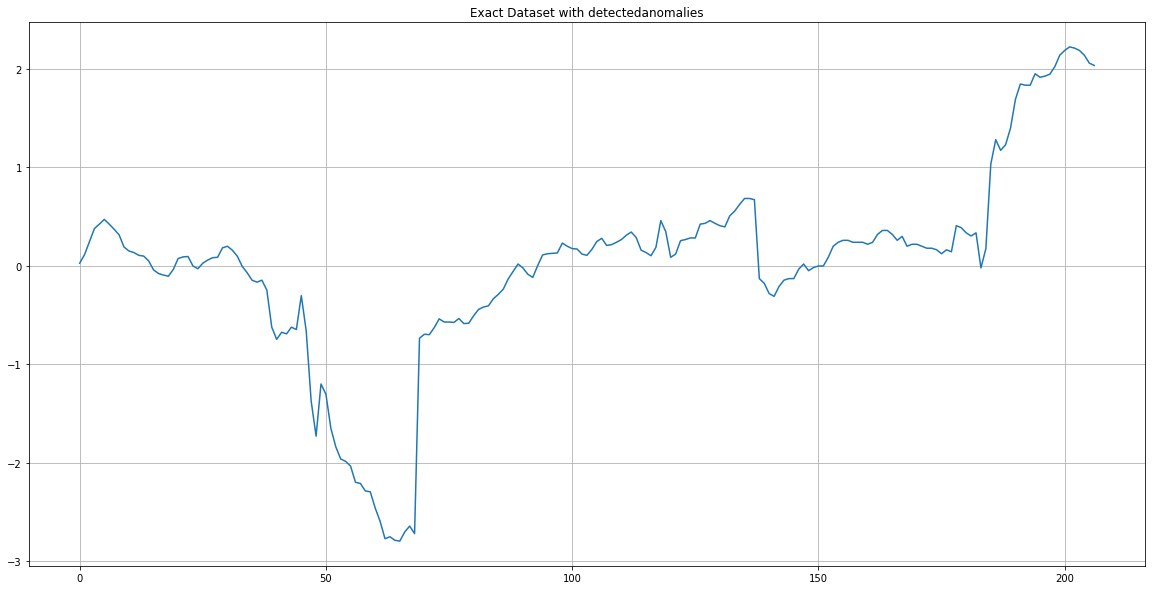


No of anomalies detected : 0, Fraction of data detected as anomaly : 0.0

 No of Anomalies detected = 0
{"header": "", "body": []}


In [12]:
data_dir = '../../dataset/sample_csv_files/'
target_dir = '../../dataset/reader_csv_files/'
assetno = ['TSFAD_A1']
model_paths = []

for i,filename in enumerate(os.listdir(data_dir)):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    kwargs1 = csv_helper.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    
    reader_kwargs1 = kwargs1
    model_input_args1 = model_input_args()
    model_input_args1['diff_order'] = 0
    training_args1 = training_args()
    training_args1['to_plot'] = True
    json_data = reader_helper.read(reader_kwargs1)
    
    kwargs1 = {**model_input_args1,**training_args1}
    train_res = json.loads(train(**kwargs1,json_data=json_data))
    model_paths.append(train_res['models'][0][assetno[0]])
    print(train_res)
    
    eval_args1 = eval_args()
    eval_args1['to_plot'] = True
    eval_args1['model_path'] = model_paths[i]
    kwargs1 = {**eval_args1}
    eval_res = evaluate(**kwargs1,json_data=json_data)
    print(eval_res)

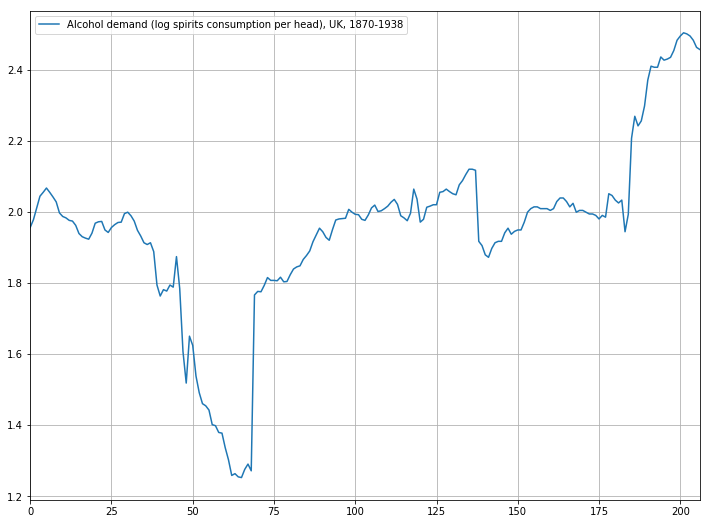

In [14]:
pd.read_csv('../../dataset/sample_csv_files/alcohol-demand-log-spirits-consu.csv').plot(figsize=(12,9))

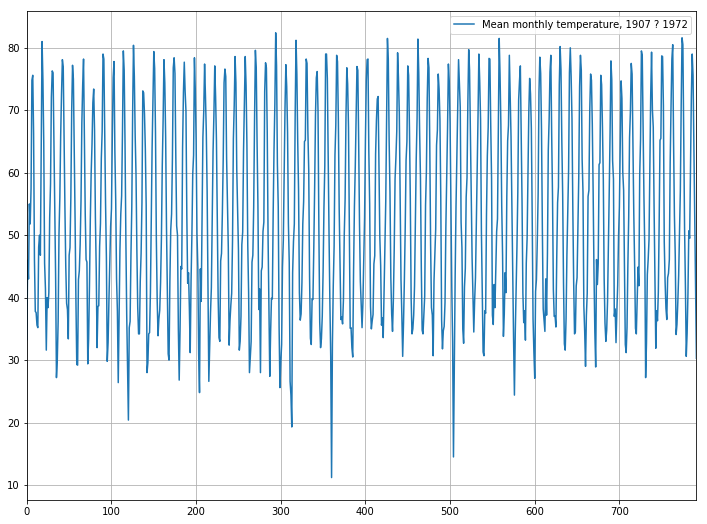

In [16]:
pd.read_csv('../../dataset/sample_csv_files/mean-monthly-temperature-1907-19.csv').plot(figsize=(12,9))

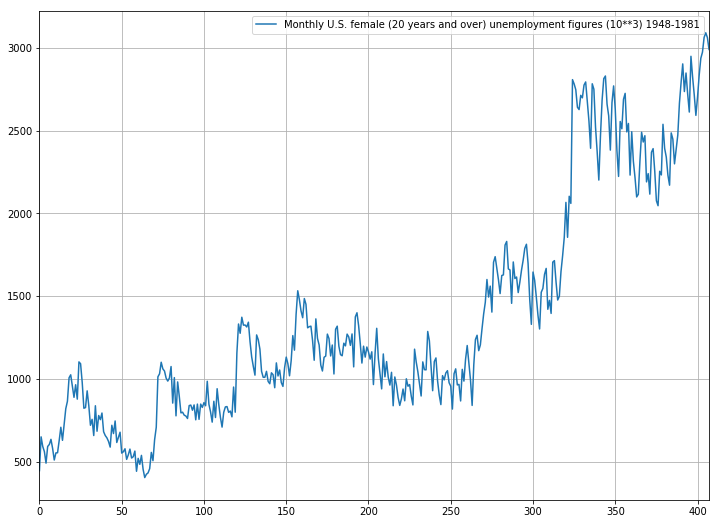

In [15]:
pd.read_csv('../../dataset/sample_csv_files/monthly-us-female-20-years-and-o.csv').plot(figsize=(12,9))

## Performance or Algorithm Tuning Test:

#### Comment out this to check the performance of the Algorithm by finetuning the hyperparameters

In [ ]:
# model_input_args = lambda :{
#     'network_shape':(8,8),
#     'input_feature_size':None,
#     'time_constant':None,
#     'minNumPerBmu':2,
#     'no_of_neighbours':3,
#     'init_radius':0.4,
#     'init_learning_rate':0.01,
#     'N':100,    
#     'diff_order':1
# }

# training_args = lambda:{
#             'is_train':True,
#             'epochs':5,
#             'batch_size':4,
#             'to_plot':True,
#             'test_frac':0.7
#         }

In [ ]:
# data_dir = 'dataset/one_csv/'
# target_dir = 'dataset/reader_csv_files/'
# assetno = ['1']
# difforders = [1,0,0,2,2,1]

# model_input_args1 = model_input_args()
# training_args1 = training_args()

# init_radiuses = [0.01,0.025,0.05,0.1,0.25,0.5,1,1.5]
# no_neighbors = [2,4,6,8,10,12,14,16,20,25]
# init_learning_rates = [0.0001,0.001,0.01,0.05,0.1,0.25,0.5]
# minPerBmus = [1,2,4,6,8,10,12]


# for i,filename in enumerate(os.listdir(data_dir)):
#     for rad in init_radiuses:
#         for no_neighbor in no_neighbors:
#             for minPerBmu in minPerBmus:
#                 for init_learning_rate in init_learning_rates:
#                     model_input_args1['init_learning_rate'] = init_learning_rate
#                     model_input_args1['minNumPerBmu'] = minPerBmu
#                     model_input_args1['no_of_neighbours'] = no_neighbor
#                     model_input_args1['init_radius'] = rad
                    
#                     print("\nModel args :Learnrate : {},minbmu:{},neighbors:{},init_Rad:{}\n".format(init_learning_rate,
#                                                                                                     minPerBmu,no_neighbor,rad))
#                     name,ext = os.path.splitext(filename)
#                     if ext != '.csv':continue
#                     infile = os.path.join(data_dir,filename)
#                     print("\nDetecting anomalies for {}\n".format(filename))


#                     kwargs1 = csv_reader.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])

#                 #     print('params: {}\n'.format(param))
#                     reader_kwargs1 = kwargs1
#                     model_input_args1 = model_input_args()
#                     model_input_args1['diff_order'] = 0
#                     training_args1 = training_args()
#                     kwargs1 = {**reader_kwargs1,**model_input_args1,**training_args1}
#                     res = main(**kwargs1,anom_thres=2.5)
#                     print(res)